# CSE416 - Final Project: Link Prediction

name: Angelica Tao Zhu, Yue Lin

In [2]:
import networkx as nx
import numpy as np

# load General Relativity and Quantum Cosmology collaboration network from text file
collaboration_network = nx.Graph()
with open("dataset/ca-GrQc.txt", "r") as fp:
    line = fp.readline()
    # skip comments
    while line[0] == '#':
        line = fp.readline()
        
    while line:
        edge = line.split()
        collaboration_network.add_edge(edge[0], edge[1])
        line = fp.readline()

# load facebook ego network
facebook_ego = nx.Graph()
with open("dataset/facebook_combined.txt", "r") as fp:
    line = fp.readline()
        
    while line:
        edge = line.split()
        facebook_ego.add_edge(edge[0], edge[1])
        line = fp.readline()
        
# load email-Eu-core temporal network
email_eu = nx.Graph()
with open("dataset/email-Eu-core-temporal.txt", "r") as fp:
    line = fp.readline()
    while line:
        edge = line.split()
        email_eu.add_edge(edge[0], edge[1])
        line = fp.readline()

In [3]:
def loadGraph(fileName):
    g = nx.Graph()
    with open("dataset/" + fileName + ".txt", "r") as fp:
        line = fp.readline()
        
        # skip comments
        while line[0] == '#':
            line = fp.readline()
            
        while line:
            edge = line.split()
            g.add_edge(edge[0], edge[1])
            line = fp.readline()
    return g

In [4]:
def splitFile(fileName, percentage):
    filePath = 'dataset/' + fileName + '.txt'
    num_lines = sum(1 for line in open(filePath))
    num_train_lines = int(num_lines * percentage)
    with open(filePath) as fp:
        count = 1
        line = fp.readline()
        
        trainf = open('dataset/' + fileName + '_train.txt', "a")
        while count < num_train_lines:
            trainf.write(line)
            line = fp.readline()
            count += 1
        
        testf = open('dataset/' + fileName + '_test.txt', "a")
        while line:
            testf.write(line)
            line = fp.readline()

In [5]:
def _apply_prediction(G, func, ebunch=None):
    """Applies the given function to each edge in the specified iterable
    of edges.

    `G` is an instance of :class:`networkx.Graph`.

    `func` is a function on two inputs, each of which is a node in the
    graph. The function can return anything, but it should return a
    value representing a prediction of the likelihood of a "link"
    joining the two nodes.

    `ebunch` is an iterable of pairs of nodes. If not specified, all
    non-edges in the graph `G` will be used.

    """
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return ((u, v, func(u, v)) for u, v in ebunch)

In [6]:
def jaccard_coefficient(G, ebunch=None):
    """Compute the Jaccard coefficient of all node pairs in ebunch.

    Jaccard coefficient of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.

    Examples
    --------
    >>> import networkx as nx
    >>> G = nx.complete_graph(5)
    >>> preds = nx.jaccard_coefficient(G, [(0, 1), (2, 3)])
    >>> for u, v, p in preds:
    ...     '(%d, %d) -> %.8f' % (u, v, p)
    ...
    '(0, 1) -> 0.60000000'
    '(2, 3) -> 0.60000000'

    References
    ----------
    .. [1] D. Liben-Nowell, J. Kleinberg.
           The Link Prediction Problem for Social Networks (2004).
           http://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    """
    def predict(u, v):
        union_size = len(set(G[u]) | set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [6]:
def sorensen_index(G, ebunch=None):
    """Compute the Sorensen Index of all node pairs in ebunch.

    Sorensen Index of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u)| + |\Gamma(v)|}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        union_size = len(set(G[u])) + len(set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [7]:
def salton_cosine_similarity(G, ebunch=None):
    """Compute the Salton Cosine Similarity of all node pairs in ebunch.

    Salton Cosine Similarity of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{\sqrt{|\Gamma(u)| \times |\Gamma(v)|}}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        import math
        union_size = math.sqrt(len(set(G[u])) * len(set(G[v])))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [8]:
def preferential_attachment(G, ebunch=None):
    """Compute the Preferential Attachment of all node pairs in ebunch.

    Preferential Attachment of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{\sqrt{|\Gamma(u)| \times |\Gamma(v)|}}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        return len(set(G[u])) * len(set(G[v]))
    return _apply_prediction(G, predict, ebunch)

In [7]:
def rank(pred):
    """
    Parameters
    ----------
    pred : An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.

    k : keep top k element based p

    Returns
    -------
    top k list
    """
    l = [(u, v, p) for u, v, p in pred]
    
    sorted_l = sorted(l, key=lambda x: x[2], reverse=True)
    return sorted_l

In [8]:
splitFile('email-Eu-core-temporal', 0.9)
email_train_g = loadGraph('email-Eu-core-temporal_train')

In [11]:
pred = salton_cosine_similarity(email_train_g)
# print(res)

In [12]:
# evaluating prediction quality

def prediction_eval(G, true_links, pred_links):
    """
    G: network before prediction
    """
    true_links = set(true_links)
    pred_links = set(pred_links)
    TP = 0; TN = 0; FP = 0; FN = 0

    for u, v in nx.non_edges(G):
        in_true_links = ((u,v) in true_links or (v,u) in true_links)
        in_pred_links = ((u,v) in pred_links or (v,u) in pred_links)
        
        if in_true_links and in_pred_links:
            TP += 1
        elif not in_true_links and in_pred_links:
            FP += 1
        elif in_pred_links and not in_pred_links:
            FN += 1
        else:
            TN += 1
    
#     print (TP, FP, FN, TN)
#     precision = TP / (TP + FP)
    return TP, FP, FN, TN

In [13]:
# load true links
def load_true_links(filename):
    # load true links
    true_links = []
    with open(filename, "r") as fp:
        line = fp.readline()

        # skip comments
        while line[0] == '#':
            line = fp.readline()

        while line:
            edge = line.split()
            true_links.append((edge[0], edge[1]))
            line = fp.readline()
    
    return true_links

In [14]:
def katz_based_metric(G, cutoff=3, beta=0.8, ebunch=None):
    """Compute the Katz based metric of all node pairs in ebunch.

    Katz based metric of nodes `u` and `v` is defined as

    .. math::

        Katz(x, y) = βA + β2A2 + β3A3 + ...

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        curB = 1
        katz = 0
        c = compute_num_of_path(email_train_g, u, v, cutoff)
        for i in range(1, cutoff + 1):
            curB *= beta
            katz += curB * c[i]
        return katz
    return _apply_prediction(G, predict, ebunch)

In [15]:
def local_path_based_metric(G, alpha=0.8, ebunch=None):
    """Compute the Local Path based metric of all node pairs in ebunch.

    Local Path based metric of nodes `u` and `v` is defined as

    .. math::

        lp(x, y) = A2 + alpha*A3...

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        c = compute_num_of_path(email_train_g, u, v, 3)
        return c[2] + alpha * c[3]
    return _apply_prediction(G, predict, ebunch)

In [61]:
def commute_time_based_metric(G, ebunch=None):
    """Compute the commute time based metric of all node pairs in ebunch.

    commute time based metric of nodes `u` and `v` is defined as

    .. math::

        CT(x, y) = HT(x, y) + HT(y, x) = m(L†x,x + L†y,y − 2L†x,y),

    where L† is the pseudo-inverse of matrix L = DA − A and m is number of edges in a social network.

    """
    import networkx as nx, numpy as np
    nodelist = sorted(G.nodes)
    L = nx.laplacian_matrix(G, nodelist=nodelist).toarray()
    CTK = np.linalg.pinv(L) # L†
    m = len(G.edges())
    def predict(u, v):
        ind_u = nodelist.index(u)
        ind_v = nodelist.index(v)
        return 1/((CTK[ind_u][ind_u] + CTK[ind_v][ind_v] - 2*CTK[ind_v][ind_u]))
    return _apply_prediction(G, predict, ebunch)

In [ ]:
def personalized_pagerank(G, ebunch=None):
    """Compute the page rank based metric of all node pairs in ebunch.

    personalized(rooted) page rank based metric of nodes `u` and `v` is defined as

    .. math::

        RPR = (1 − )(I − D−1A)−1.

   where D is the diagonal matrix  with Di,i = Sum(j Ai,j).

    """
    def predict(u, v):
        return nx.pagerank(G,personalization={u : v})
    return _apply_prediction(G, predict, ebunch)

In [62]:
pred = commute_time_based_metric(email_train_g)
res = rank(pred, 2000)

In [16]:
import collections
def compute_num_of_path(G, u, v, cutoff):
    paths = nx.all_simple_paths(G, source=u, target=v, cutoff=cutoff)
    paths_len = [len(path) - 1 for path in paths]
    return collections.Counter(paths_len)

In [30]:
pred = local_path_based_metric(email_train_g)

In [19]:
c = compute_num_of_path(email_train_g, '587', '245', 3)
cutoff = 3
beta = 0.8
curB = 1
katz = 0
for i in range(1, cutoff + 1):
    curB *= beta
    katz += curB * c[i]
print(katz)

380.1920000000001


In [39]:
# TP, FP, FN, TN

pred = preferential_attachment(email_train_g)
res = rank(pred, 2000)

pred_pairs = [(u,v) for u,v,p in res]
true_links = load_true_links("dataset/email-Eu-core-temporal_test.txt")
TP, FP, FN, TN = prediction_eval(email_train_g, true_links, pred_pairs)
precision = TP / (TP + FP)
print(precision)

0.067


In [29]:
def pred_iter_to_list(it):
    l = []
    for u, v, p in it:
        l.append((u,v,p))
    return l

In [32]:
def iter_to_list(it):
    l = []
    for val in it:
        l.append(val)
    return l

In [34]:
import numpy as np

x = []
precisions = []
TPs = []
FPs = []
FNs = []
TNs = []

pred = sim_rank_metric(email_train_g)
pred = pred_iter_to_list(pred)
true_links = load_true_links("dataset/email-Eu-core-temporal_test.txt")
pred = rank(pred)

for i in np.arange(5,len(pred),1000):
    res = pred[0: i]
#     print(res)
    pred_pairs = [(u,v) for u,v,p in res]
    TP, FP, FN, TN = prediction_eval(email_train_g, true_links, pred_pairs)
    x.append(i)
    TPs.append(TP)
    FPs.append(FP)
    TNs.append(TN)
    FNs.append(FN)
    precision = TP / (TP + FP)
    precisions.append(precision)
    print(i)

KeyboardInterrupt: 

In [73]:
len(pred)

459640

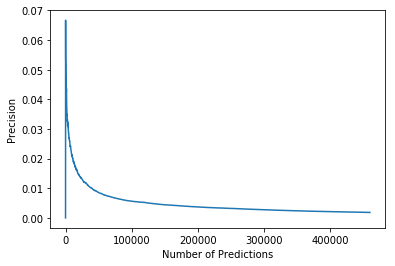

In [78]:
import matplotlib.pyplot as plt

# plot graph
plt.plot(x, precisions,'-')
plt.xlabel('Number of Predictions')
plt.ylabel('Precision')
# save graph to local file
# plt.savefig("degree_distribution.png", dpi=400) # save as png
plt.show()

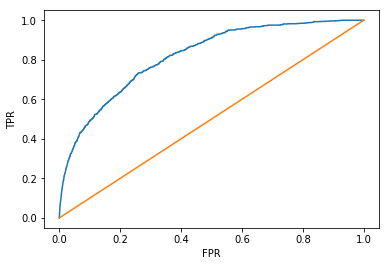

In [81]:
import matplotlib.pyplot as plt
#ROC
FPRs = [FPs[i] / (FPs[i] + TNs[i]) for i in range(len(FPs))]
TPRs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(TPs))]
plt.plot(FPRs, TPRs,'-')
plt.xlabel('FPR')
plt.ylabel('TPR')
# save graph to local file
# plt.savefig("degree_distribution.png", dpi=400) # save as png
x = np.arange(0,1.1,0.1)
plt.plot(x, x,'-')
plt.show()

In [17]:
preds = nx.jaccard_coefficient(email_train_g)
count = 0
l = []
for u, v, p in preds:
    if p > 0:
        l.append((u, v, p))
#     print('(%s, %s) -> %.8f' % (u, v, p))

KeyboardInterrupt: 

In [57]:
G = nx.complete_graph(5)
preds = nx.jaccard_coefficient(G)
for u, v, p in preds:
    print('(%d, %d) -> %.8f' % (u, v, p))

In [25]:
# https://stackoverflow.com/questions/9767773/calculating-simrank-using-networkx

from collections import defaultdict
import copy
import sys

def simrankmatrix(G, r=0.9, max_iter=100):
    # init. vars
    sim_old = defaultdict(list)
    sim = defaultdict(list)
    for n in G.nodes():
        sim[n] = defaultdict(int)
        sim[n][n] = 1
        sim_old[n] = defaultdict(int)
        sim_old[n][n] = 0

    # recursively calculate simrank
    for iter_ctr in range(max_iter):
        if _is_converge(sim, sim_old):
            break
        sim_old = copy.deepcopy(sim)
        for u in G.nodes():
            for v in G.nodes():
                if u == v:
                    continue
                s_uv = 0.0
                for n_u in G.neighbors(u):
                    for n_v in G.neighbors(v):
                        s_uv += sim_old[n_u][n_v]
                sim[u][v] = (r * s_uv / (len(iter_to_list(G.neighbors(u))) * len(iter_to_list(G.neighbors(v)))))
    return sim

def _is_converge(s1, s2, eps=1e-4):
    for i in s1.keys():
        for j in s1[i].keys():
            if abs(s1[i][j] - s2[i][j]) >= eps:
                return False
    return True

In [15]:
def sim_rank_metric(G, ebunch=None):
    """Compute the commute time based metric of all node pairs in ebunch.

    commute time based metric of nodes `u` and `v` is defined as

    .. math::

        CT(x, y) = HT(x, y) + HT(y, x) = m(L†x,x + L†y,y − 2L†x,y),

    where L† is the pseudo-inverse of matrix L = DA − A and m is number of edges in a social network.

    """
    import networkx as nx, numpy as np
    nodelist = sorted(G.nodes)
    sim_rank_matrix = simrankmatrix(G)
    def predict(u, v):
        ind_u = nodelist.index(u)
        ind_v = nodelist.index(v)
        return sim_rank_matrix[ind_u][ind_v]
    return _apply_prediction(G, predict, ebunch)